# Workspace \#8: Parameter Space

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md
import green as gr

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.

In [22]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]
ga_cast = 6.e-11 # [GeV^-1]

In [4]:
help(gr.load_green_results)

Help on function load_green_results in module green:

load_green_results(name, r=None, tex=0.0, nuB=1.0)
    Function that loads the CCV numerical results for the SNRs from Green's Catalog.



### TODO: allow for ``r==None``, i.e., for SNRs with known age.

In [14]:
# SNR properties
r = 30.
tex = 0.
nuB = 8.

# axion parameters
ga_ref = 1.e-10
nu_pivot = 1.
ma_ref = pt.ma_from_nu(nu_pivot)

# reach:
sn_th = 2.
sigs_th = 2.
out_sigs = (gr.sigs_Gr > sigs_th)

min_ga = {}
min_ga_sigs = {}
pars_sigs = {}
for name, snr in tqdm(gr.snrs_cut.items()):
    
    sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(name, r=r, tex=tex, nuB=nuB)

    _, ga_Gr, _, _, no_Gr = gr.snr_reach(name,
                                         r=r,
                                         nuB=nuB,
                                         tex=tex,
                                         sn_ratio_threshold=sn_th,
                                         full_output=True)
    # minimum ga
    min_ga[name] = ga_Gr.min()
    
    # minimum ga within sigmas threshold
    ga_within = np.ma.masked_array(ga_Gr, mask=out_sigs)
    ga_lowest_idx = ga_within.argmin()
    ga_lowest = (ga_Gr.flatten())[ga_lowest_idx]
    
    min_ga_sigs[name] = ga_lowest
    pars_sigs[name] = {'tpk':(gr.pre_tpk_Gr.flatten())[ga_lowest_idx],
                       'Lpk':(gr.pre_Lpk_Gr.flatten())[ga_lowest_idx]}

100%|██████████| 61/61 [00:20<00:00,  3.02it/s]


In [15]:
min_key = min(min_ga, key=min_ga.__getitem__)
print("Absolute smallest ga in SNR: \n{}, ga = {}".format(min_key, min_ga[min_key]))

min_sigs_key = min(min_ga_sigs, key=min_ga_sigs.__getitem__)
print("\nSmallest ga within {}-sigmas in SNR:\n{}, ga = {}".format(sigs_th, min_sigs_key, min_ga_sigs[min_sigs_key]))
print("\tCorresponding parameters: {}".format(pars_sigs[min_sigs_key]))

Absolute smallest ga in SNR: 
G111.7-2.1, ga = 6.23871184211e-12

Smallest ga within 2.0-sigmas in SNR:
G4.5+6.8, ga = 1.77149191606e-10
	Corresponding parameters: {'Lpk': 1.1874815363065927e+28, 'tpk': 414.95404263436325}


In [34]:
# Exploring results:
name = min_key
snr = gr.snrs_cut[min_key]

print(name)

NL, Nt = 0., -3

Lpk = 10.**(ct._mu_log10_Lpk_ + NL*ct._sig_log10_Lpk_)
tpk = 10.**(ct._mu_log10_tpk_ + Nt*ct._sig_log10_tpk_)

L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha
new_Lpk = Lpk*from_Bieten_to_pivot

lightcurve_params = {'t_peak': tpk,
                     'L_peak': new_Lpk,
                     'L_today': L0}
t_trans = r*(lightcurve_params['t_peak']/365.)
lightcurve_params.update({'t_trans':t_trans})

t_age = ap.tage_compute(new_Lpk, tpk, t_trans, L0, gamma)

age_steps = int(1000.*(log10(t_age) - log10(tpk/365.)) + 1)
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}

print("t_trans=%.1e, t_age=%.1e, tpk=%.1e" % (t_trans, t_age, tpk/365.))

md.snr_routine(ma_ref, ga_ref,
               snr,
               lightcurve_params=lightcurve_params,
               snu_echo_kwargs=snu_echo_kwargs,
               data=data,
               output_all=True,
               verbose=0)

G111.7-2.1
t_trans=8.2e-03, t_age=3.1e-03, tpk=2.7e-04


(2.4687226885933304e-07,
 {'S/N': 2.4687226885933304e-07,
  'echo_Snu': 7.781113754590662e-13,
  'ga': 1e-10,
  'ma': 8.27133561166016e-06,
  'noise_Omega_obs': 1.6614302187698022e-06,
  'noise_Omega_res': array(7.20993788e-08),
  'noise_T408': array(69.87706757),
  'noise_Tnu': 32.82974756570012,
  'noise_delnu': 0.001,
  'noise_nu': 1.0,
  'noise_power': 7.468787643025209e-17,
  'signal_Omega': 1.6614302187698022e-06,
  'signal_S_echo': 1.2447155971781575e-42,
  'signal_Snu': 7.781113754590662e-13,
  'signal_delnu': 0.001,
  'signal_nu': 1.0,
  'signal_power': 1.8438365510621838e-23})

In [26]:
# Selecting a SNR to explore:
name = min_key
snr = gr.snrs_cut[name]

sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(min_key, r=r, tex=tex, nuB=nuB)

_, ga_Gr, _, _, no_Gr = gr.snr_reach(min_key,
                                     r=r,
                                     nuB=nuB,
                                     tex=tex,
                                     sn_ratio_threshold=2.,
                                     full_output=True)

short_age = (time_Gr < r*(gr.pre_tpk_Gr/365.)).astype(int)

/home/buenabad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


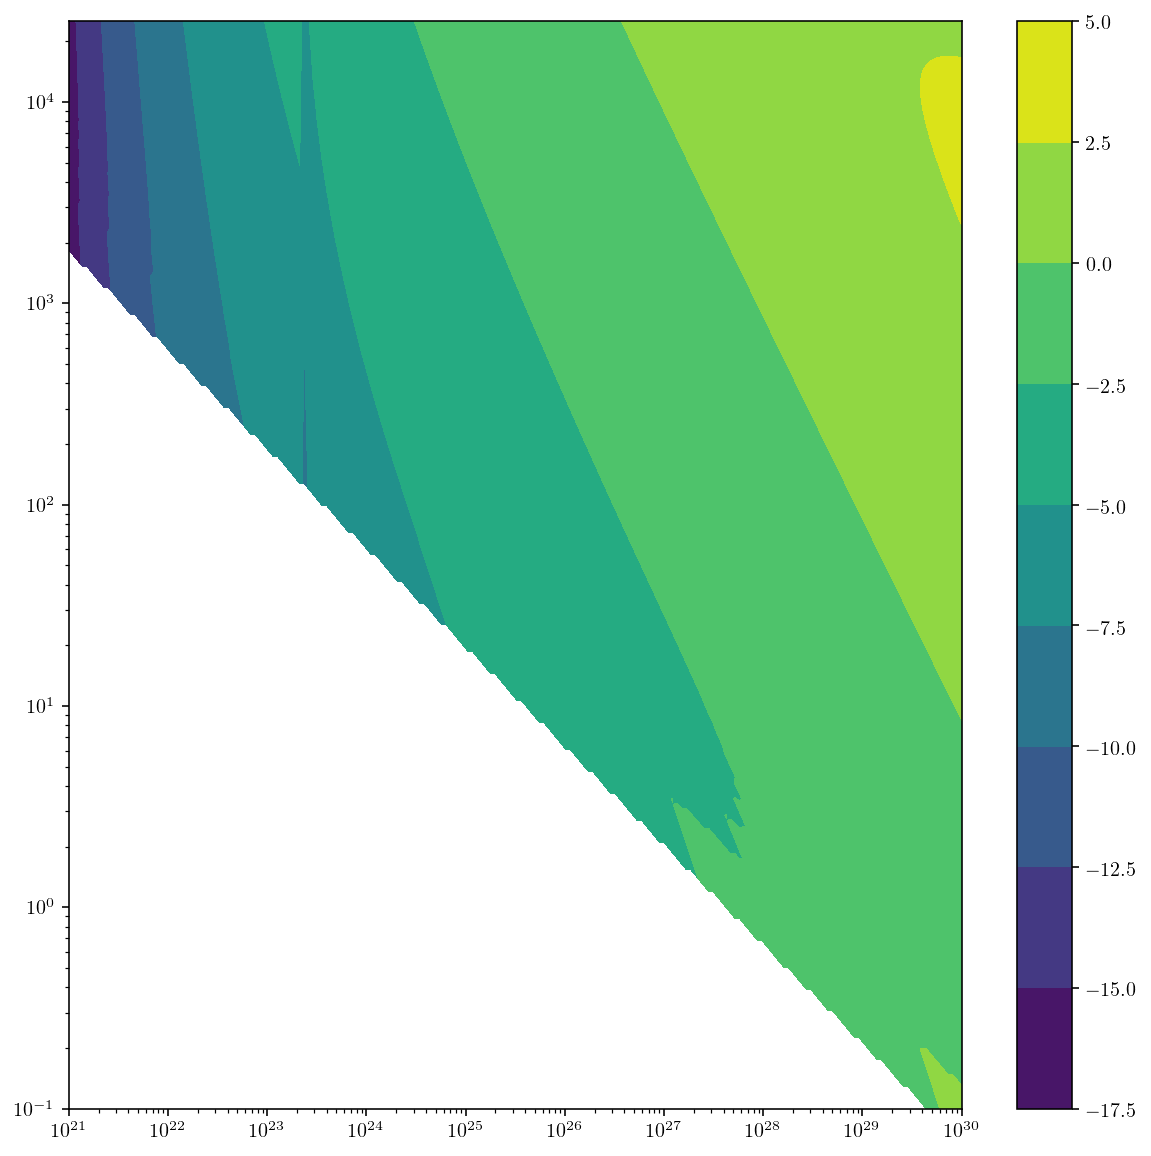

In [27]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

# contours for best possible ga
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(gr.pre_tpk_Gr))
cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(sn_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(echo_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(time_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, short_age)

fig.colorbar(cs)

plt.xscale("log"),plt.yscale("log");

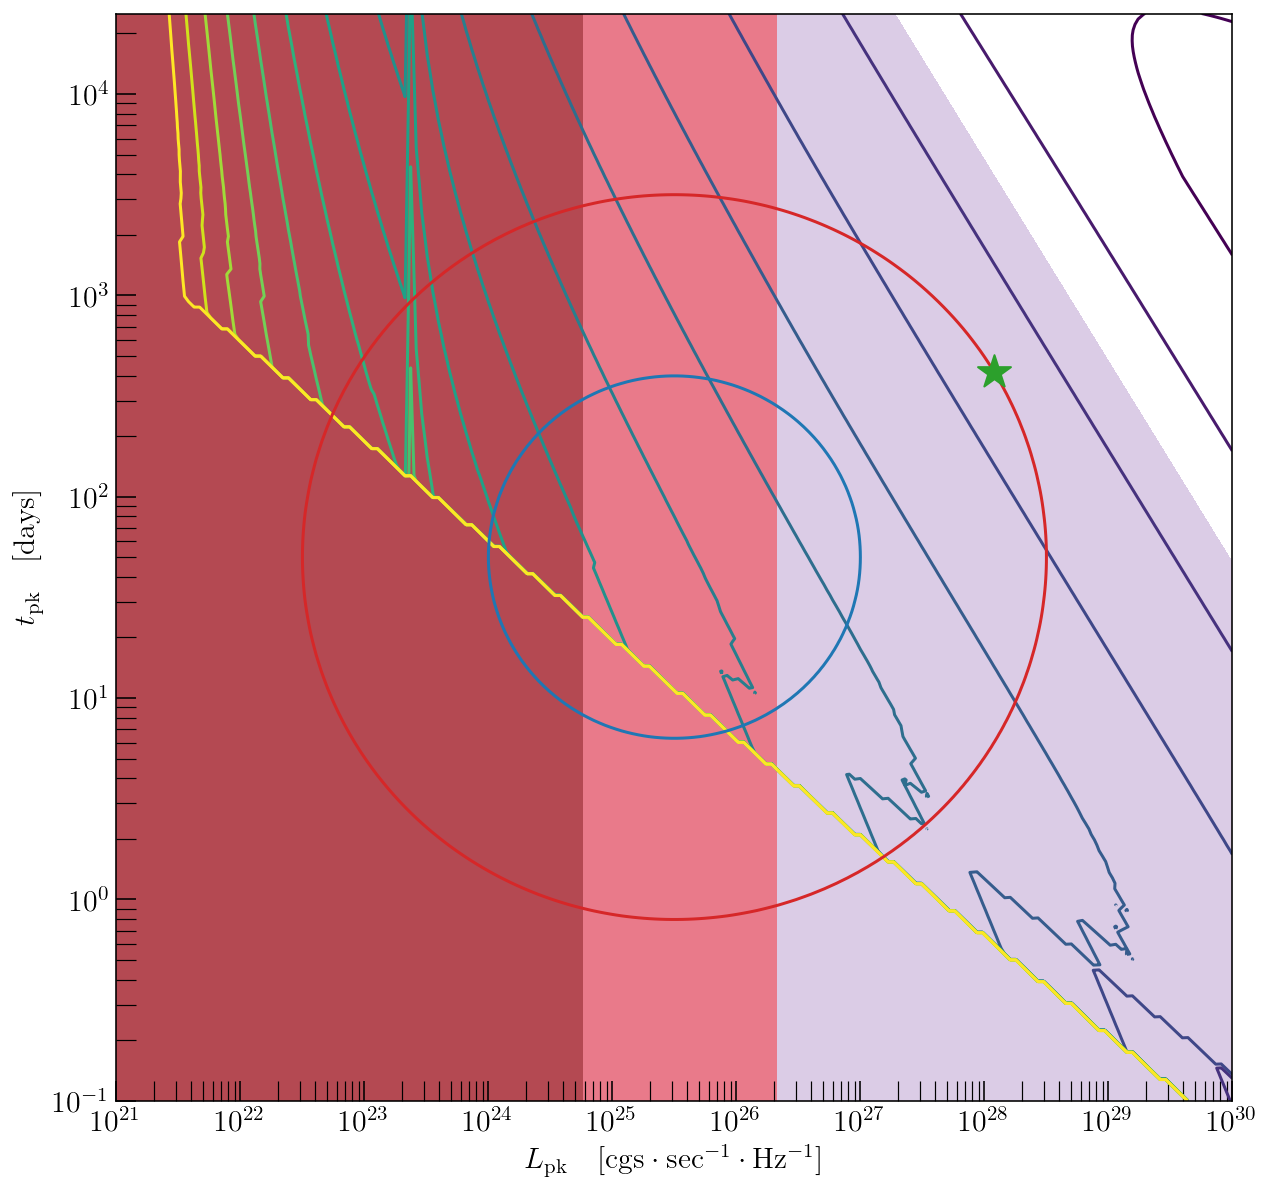

In [29]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

ga_lvls = np.arange(-14., -3.5, 0.5) # axion photon coupling levels
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha

# contours for best possible ga
ax.contour(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(ga_Gr), levels=ga_lvls)

ax.scatter(pars_sigs[name]['Lpk'], pars_sigs[name]['tpk'], s=300., zorder=10., marker='*', color="C2")

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['indigo'], alpha=0.2, zorder=-1)

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, no_Gr, levels=[0.999, 1.1], colors=['k'], alpha=0.4, zorder=-1)

ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, short_age, levels=[0.999, 1.1], colors=['r'], alpha=0.4, zorder=-1)

ax.contour(gr.pre_Lpk_arr, gr.pre_tpk_arr, gr.sigs_Gr, levels=[1., 2.], colors=['C0', 'C3'], linestyles=['-', '-'])

plt.xscale("log"),plt.yscale("log");
ax.set_ylabel(r"$t_{\rm pk}\quad[\mathrm{days}]$", fontsize=label_sz);
ax.set_xlabel(r"$L_{\rm pk}\quad[\mathrm{cgs \cdot sec^{-1} \cdot Hz^{-1}}]$", fontsize=label_sz);
ax.set_xscale("log");ax.set_yscale("log");
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

In [35]:
# ma-ga
Lpk = pars_sigs[name]['Lpk']*from_Bieten_to_pivot
tpk = pars_sigs[name]['tpk']
L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)

light_curve_params = {'L_peak':Lpk,
                      't_peak':tpk,
                      'L_today':L0}

if r != None:
    t_trans = r*(tpk/365.)
    light_curve_params.update({'t_trans':t_trans})
    t_age = ap.tage_compute(Lpk, tpk, t_trans, L0, gamma)
else:
    t_age = snr.age
    light_curve_params.update({'t_age':t_age})


age_steps = int(1000.*(log10(t_age) - log10(tpk/365.)) + 1)
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}


nu_arr = np.concatenate((np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), 101), np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), 101)))
ma_arr = pt.ma_from_nu(nu_arr)

z, new_output = md.snr_routine(ma_arr, ga_ref,
                               snr,
                               gamma=gamma,
                               nu_pivot=nu_pivot,
                               lightcurve_params=light_curve_params,
                               snu_echo_kwargs=snu_echo_kwargs,
                               data=data,
                               output_all=True,
                               verbose=0)

ma_ga = ec.ma_ga_bound(2., ma_arr, z, ga_ref)

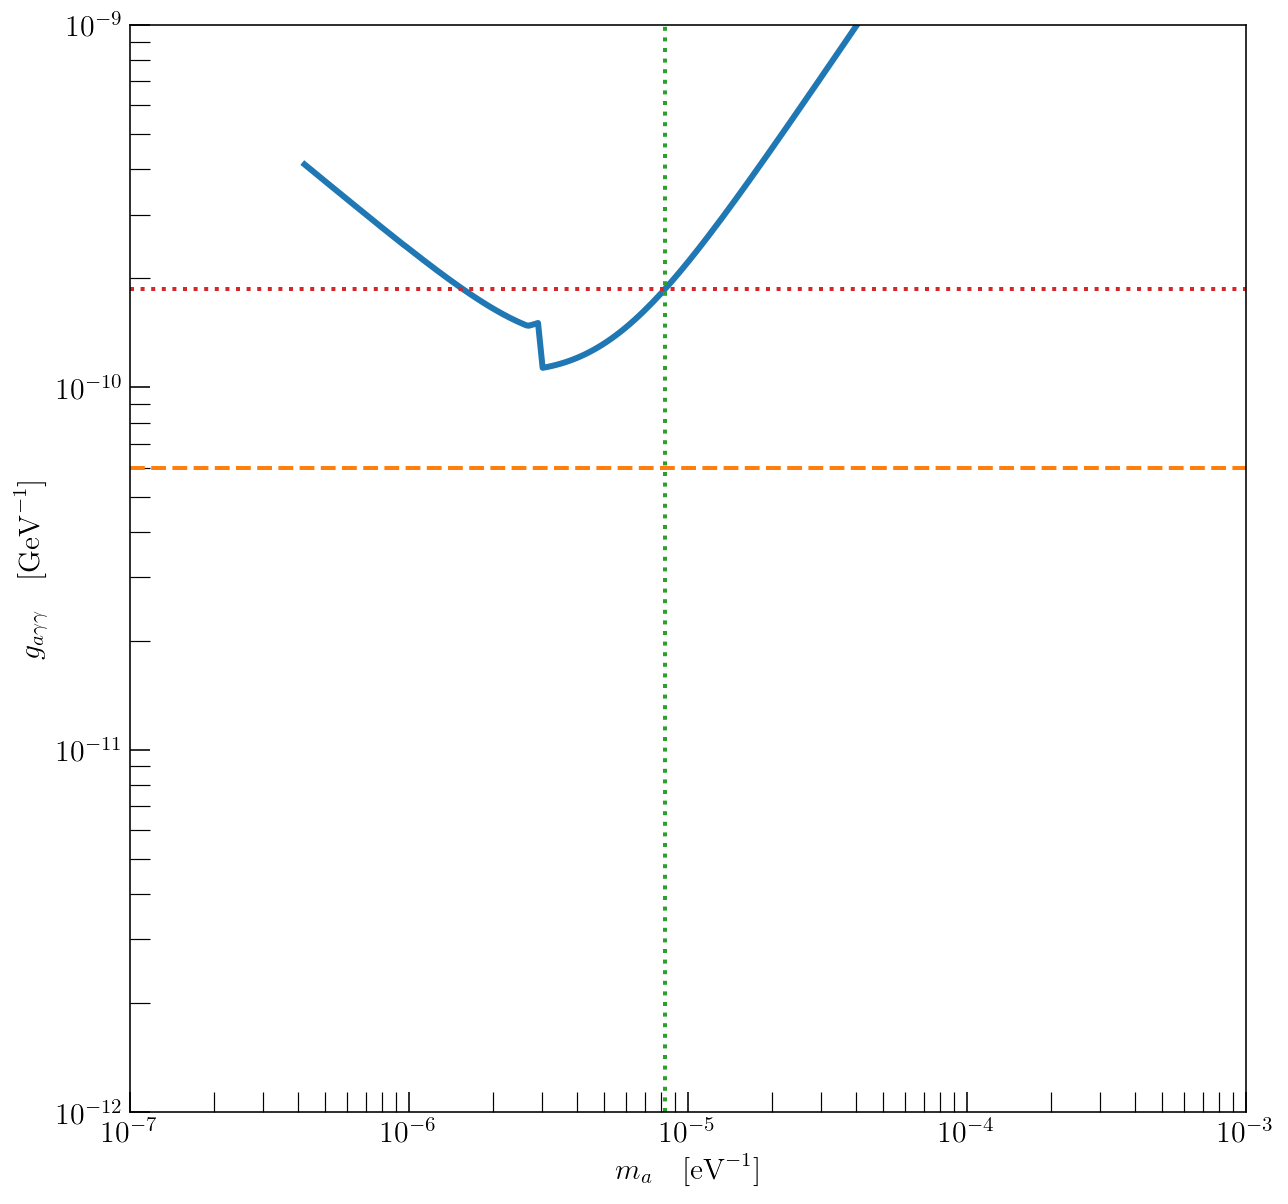

In [36]:
plt.loglog(ma_ga[:,0], ma_ga[:,1], lw=3., color='C0')
plt.axhline(ga_cast, lw=2., color='C1', ls="--")
plt.axvline(pt.ma_from_nu(1.), lw=2., color="C2", ls=":")
plt.axhline(min_ga_sigs[name], lw=2., color='C3', ls=":")

# plt.title(title, fontsize=title_sz);
plt.ylabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.xlabel(r"$m_a\quad[\mathrm{eV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);

plt.xlim(1.e-7, 1.e-3);plt.ylim(1.e-12, 1.e-9);
# plt.savefig(file_name, bbox_inches="tight")